In [1]:
!pip3 install scikit-learn
!pip3 install torch
!pip3 install torchinfo


In [2]:
!pip3 install google-colab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.8 MB/s eta 0:00:00


In [17]:
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import OneSidedSelection, InstanceHardnessThreshold, NearMiss, ClusterCentroids
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelBinarizer

In [4]:
# only for running locally
#dfs = []
#for filename in os.listdir('features_ring'):
#    if filename[-4:] == '.tsv':
#        dfs.append(pd.read_csv('features_ring/' + filename, sep='\t'))
#df = pd.concat(dfs)
#df

In [5]:
# don't need to execute - only to export df for training in cloud
#df.to_csv('contact_df.csv')

In [6]:
# only for running on drive for training
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('drive/MyDrive/StructuralBioinformatics/data/contact_df.csv')

Mounted at /content/drive


In [7]:
df.dropna(inplace=True)

# Define ground truth values
y = df['Interaction'].astype('category')
y_oneHot = pd.get_dummies(y)
y


0               VDW
1             HBOND
2             HBOND
3         PIPISTACK
4             HBOND
            ...    
454188          VDW
454189        HBOND
454190          VDW
454191        HBOND
454192        HBOND
Name: Interaction, Length: 454193, dtype: category
Categories (6, object): ['HBOND', 'IONIC', 'PICATION', 'PIPISTACK', 'SSBOND', 'VDW']

In [20]:
# Define training features
X = df[['s_rsa', 's_up', 's_down', 's_phi', 's_psi', 's_a1', 's_a2', 's_a3', 's_a4', 's_a5',
        't_rsa', 't_up', 't_down', 't_phi', 't_psi', 't_a1', 't_a2', 't_a3', 't_a4', 't_a5']]

#is this working?
X = X.fillna({col: X[col].mode()[0] for col in X.columns})

print("Scaling data...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
#X_scaled = pd.DataFrame(X_scaled, columns=X.columns) #why are we casting it to a DF?
X_scaled = np.array(X_scaled) #undersampler and oversampler expects arrays
y_oneHot = np.array(y_oneHot) #undersampler and oversampler expects arrays


print("Undersampling data...")
undersample = InstanceHardnessThreshold(estimator=AdaBoostClassifier(),sampling_strategy={0:50000,5:50000})
X_scaled, y_oneHot = undersample.fit_resample(X_scaled, y_oneHot)

print("Oversampling data...")
oversample = SMOTE(sampling_strategy={1:50000,3:50000,2:50000,4:50000})
X_scaled, y_oneHot = oversample.fit_resample(X_scaled, y_oneHot)

X_scaled
y_oneHot


Scaling data
Undersampling data...
Oversampling data...


array([[1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0]])

In [26]:
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
y_oneHot = pd.DataFrame(y_oneHot)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_oneHot, test_size=0.1, random_state=0)

n_splits=10
kf = KFold(n_splits=n_splits, shuffle=True)

In [28]:
class ContactNet(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_layers_dim=[]):
        super().__init__()
        self.layers = nn.ModuleList()
        if len(hidden_layers_dim) == 0:
            self.layers = self.layers.append(nn.Linear(input_dim, num_classes))
        else:
            for layer_idx in range(len(hidden_layers_dim)):
                if layer_idx == 0:  # first layer, from input to hidden
                    self.layers = self.layers.append(nn.Linear(input_dim, hidden_layers_dim[layer_idx]))
                else:  # hidden layers, depending on the input
                    self.layers = self.layers.append(nn.Linear(hidden_layers_dim[layer_idx-1], hidden_layers_dim[layer_idx]))
            self.layers = self.layers.append(nn.Linear(hidden_layers_dim[-1], num_classes))  # final output layer
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=.1)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.Tensor(x)
        if x.dtype != torch.float32:
            x = x.float()
        if len(self.layers) == 1:
            return self.layers[0](x)
        else:
            for layer in self.layers[:-1]:
                x = F.relu(layer(x))
        return F.log_softmax(x, dim=1)#self.layers[-1](x)

input_size = X.shape[1]  # The number of input features
num_classes = y_oneHot.shape[1] # The number of output classes

model = ContactNet(input_size, num_classes, [60, 60, 128, 128, 128, 128, 256, 256, 256, 256])

# Criterion and optimizer
criterion = nn.CrossEntropyLoss()

lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

summary(model)

Layer (type:depth-idx)                   Param #
ContactNet                               --
├─ModuleList: 1-1                        --
│    └─Linear: 2-1                       1,260
│    └─Linear: 2-2                       3,660
│    └─Linear: 2-3                       7,808
│    └─Linear: 2-4                       16,512
│    └─Linear: 2-5                       16,512
│    └─Linear: 2-6                       16,512
│    └─Linear: 2-7                       33,024
│    └─Linear: 2-8                       65,792
│    └─Linear: 2-9                       65,792
│    └─Linear: 2-10                      65,792
│    └─Linear: 2-11                      1,542
Total params: 294,206
Trainable params: 294,206
Non-trainable params: 0

In [29]:
class EarlyStopping:
    def __init__(self, tolerance, min_delta):
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if abs(validation_loss - train_loss) > self.min_delta:
            self.counter += 1
            if self.counter >= self.tolerance:
                self.early_stop = True


def train(model, optimizer, num_epochs):
    early_stopping = EarlyStopping(tolerance=10, min_delta=0.01) # slow to learn, so it has to be VERY tolerant

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    current_fold_counter=0

    for train_index, val_index in kf.split(X_train):

        current_fold_counter += 1

        early_stopping.early_stop = False
        early_stopping.counter = 0

        X_train_fold = X_train.values[train_index] #X_train (type np.ndarray) does not have any attribute called .values. Recasted to a pd.DataFrame but shouldn't be better to use a np.ndarray?
        y_train_fold = y_train.values[train_index]
        X_val_fold = X_train.values[val_index]
        y_val_fold = y_train.values[val_index]

        for epoch in range(num_epochs):
            out = model(torch.tensor(X_train_fold))
            y_train_fold_labels = np.argmax(y_train_fold, axis=1)
            loss = criterion(out, torch.tensor(y_train_fold_labels).long())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            with torch.no_grad():
              val_outputs = model(X_val_fold)
              y_val_fold_labels = np.argmax(y_val_fold, axis=1)
              val_loss =  criterion(val_outputs, torch.tensor(y_val_fold_labels).long())
              _, val_preds = torch.max(val_outputs, 1)
              val_accuracy = accuracy_score(y_val_fold_labels, val_preds)
              train_accuracy = accuracy_score(y_train_fold_labels, torch.argmax(out, 1))


            print(f'Fold: #{current_fold_counter}/{n_splits} - Epoch {epoch+1}/{num_epochs}')
            print(f'Train Loss: {loss.item()} - Validation Loss: {val_loss.item()} - Train Accuracy: {train_accuracy} - Validation Accuracy: {val_accuracy}')

            train_losses.append(loss.item())
            val_losses.append(val_loss.item())
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)


            # Check for early stopping
            #early_stopping(loss.item(), val_loss.item())
            #if early_stopping.early_stop:
            #    print('Early stopping triggered...')
            #    break

        #if early_stopping.early_stop:
        #    break

    return train_losses, val_losses, train_accuracies, val_accuracies

In [30]:
EPOCHS = 50

train_loss, val_loss, train_accuracy, val_accuracy = train(model, optimizer, num_epochs=EPOCHS)

Epoch 1/50 :
Train Loss: 5.535951614379883 - Validation Loss: 5.444551467895508 - Train Accuracy: 0.0 - Validation Accuracy: 0.0007389344565137073
Epoch 2/50 :
Train Loss: 5.444034099578857 - Validation Loss: 5.316451072692871 - Train Accuracy: 0.0006609520994466066 - Validation Accuracy: 0.12354984112909186
Epoch 3/50 :
Train Loss: 5.315589427947998 - Validation Loss: 5.117056846618652 - Train Accuracy: 0.12347898911276417 - Validation Accuracy: 0.17409295795462942
Epoch 4/50 :
Train Loss: 5.116089820861816 - Validation Loss: 4.813194274902344 - Train Accuracy: 0.1722950227433207 - Validation Accuracy: 0.16792285524273998
Epoch 5/50 :
Train Loss: 4.812159061431885 - Validation Loss: 4.375351905822754 - Train Accuracy: 0.16622329507200684 - Validation Accuracy: 0.16792285524273998
Epoch 6/50 :
Train Loss: 4.374324798583984 - Validation Loss: 3.7962634563446045 - Train Accuracy: 0.16622329507200684 - Validation Accuracy: 0.16792285524273998
Epoch 7/50 :
Train Loss: 3.795619249343872 - V

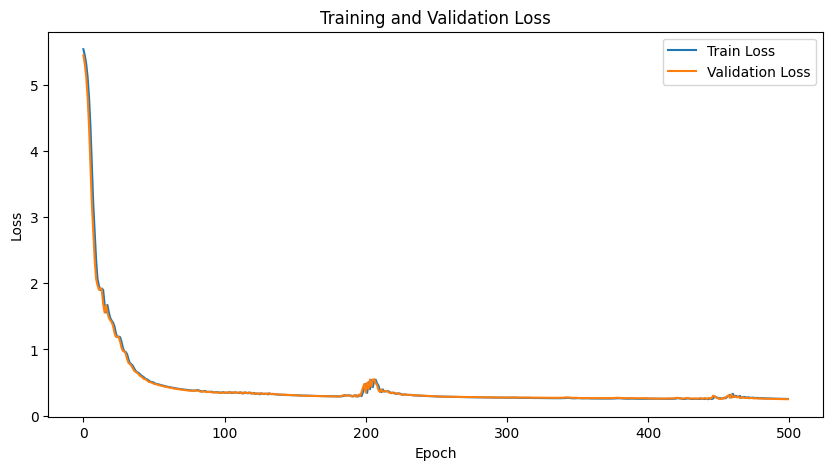

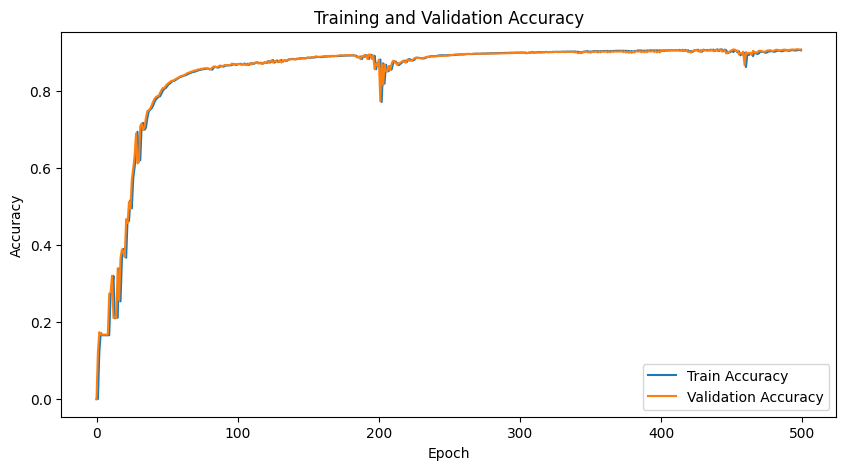

In [31]:


# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting the accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [35]:
PATH = "drive/MyDrive/StructuralBioinformatics/model/model.pth"
torch.save(model, PATH)

In [ ]:
# Load Model For Inference

model = torch.load(PATH)
model.eval()